In [93]:
import numpy as np 
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import os
from geopy.distance import geodesic

from tqdm import tqdm, trange


In [164]:

def catalog_to_dataframe(cat, client):

    if 'ncedc' in client.base_url:
        split_char = "/"
    elif 'iris' in client.base_url:
        split_char = "="
    # Lists to hold the extracted data
    event_ids = []
    origin_times = []
    qlats = []
    qlons = []
    qdeps = []
    qmags = []
    qmagtypes = []
    
    for event in cat:
        # Extracting origin information
        origin = event.origins[0] if event.origins else None
        if origin:
            if origin.depth:
                # Extracting event ID
                event_ids.append(event.resource_id.id.split(split_char)[-1])
                # print(origin)
                origin_times.append(origin.time.datetime)
                qlats.append(origin.latitude)
                qlons.append(origin.longitude)
                qdeps.append(origin.depth / 1000)  # Convert depth to km
                
                # Extracting magnitude information
                magnitude = event.magnitudes[0] if event.magnitudes else None
                if magnitude:
                    qmags.append(magnitude.mag)
                    qmagtypes.append(magnitude.magnitude_type)
                else:
                    qmags.append(None)
                    qmagtypes.append(None)
    
    # Creating the DataFrame
    df = pd.DataFrame({
        'event_id': event_ids,
        'origin_time': origin_times,
        'qlat': qlats,
        'qlon': qlons,
        'qdep': qdeps,
        'qmag': qmags,
        'qmagtype': qmagtypes
    })
    
    return df

def inventory_to_dataframe(inventory):
    # Lists to hold the extracted data
    networks = []
    stations = []
    locations = []
    channels = []
    slats = []
    slons = []
    seles = []
    sampling_rates = []
    units = []

    for network in inventory:
        for station in network:
            for channel in station:
                networks.append(network.code)
                stations.append(station.code)
                locations.append(channel.location_code)
                channels.append(channel.code)
                slats.append(station.latitude)
                slons.append(station.longitude)
                seles.append(station.elevation)
                sampling_rates.append(channel.sample_rate)
                units.append(channel.response.instrument_sensitivity.input_units)
    
    # Creating the DataFrame
    df = pd.DataFrame({
        'net': networks,
        'sta': stations,
        'loc': locations,
        'cha': channels,
        'slat': slats,
        'slon': slons,
        'sele': seles,
        'sampling_rate': sampling_rates,
        'units': units
    })
    
    return df




# https://github.com/ivandevert/sdpy

In [169]:
# # central coast
# event_lon_range = [-121.3, -120]
# event_lat_range = [35.3, 36.3]

# Mammoth
# event_lon_range = [-119.25, -118.1]
# event_lat_range = [37.0, 37.8]

# # palm springs
# event_lon_range = [-116.542773-0.5, -116.542773+0.5]
# event_lat_range = [33.823983-0.5, 33.823983+0.5]

# salton sea
event_lon_range = [-115.8588-0.3, -115.8588+0.5]
event_lat_range = [33.3579-0.5, 33.5]

t1 = UTCDateTime("2010-01-01")
t2 = UTCDateTime("2024-01-01")
m_range = [1.39, 10]


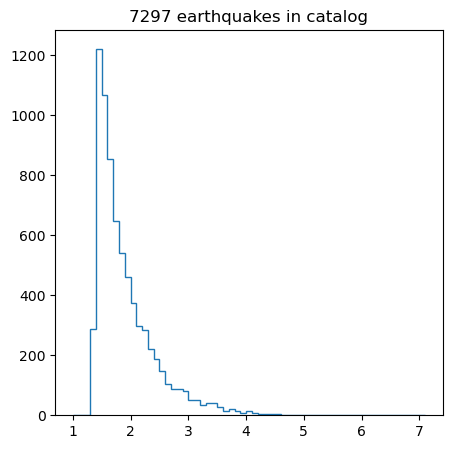

In [181]:
client = Client("IRIS")
try:
    cat = pd.read_csv('data/event_list.txt')
except:
    print("Error reading event_list.txt, downloading event catalog...")
    catalog = client.get_events(
        starttime=t1,
        endtime=t2,
        minlatitude=event_lat_range[0],
        maxlatitude=event_lat_range[1],
        minlongitude=event_lon_range[0],
        maxlongitude=event_lon_range[1],
        minmagnitude=m_range[0],
        maxmagnitude=m_range[1],
    )
    cat = catalog_to_dataframe(catalog, client)
    cat = cat.sort_values(by='event_id').reset_index(drop=True)
    cat.to_csv('data/event_list.txt', index=False)

plt.figure(figsize=(5,5))
plt.title(f"{len(cat)} earthquakes in catalog")
plt.hist(cat['qmag'], bins=np.arange(1, 7.2, 0.1), histtype='step')
plt.show()

In [175]:
# Initialize client
client = Client("IRIS")

# Folder to store raw seismograms
raw_seismograms_folder = "data/raw_seismograms/"
if not os.path.exists(raw_seismograms_folder):
    os.makedirs(raw_seismograms_folder)

# Variables
# channels = "H?Z"  # Example channel; replace with your specific channels
channels = "HHZ"
maxradius = 1.0   # Example maxradius in degrees; replace with your specific value
station_maxradius = 1.25

# Get station information once outside the loop
try:
    inv = pd.read_csv('data/station_list.txt', keep_default_na=False)
except:
    print("Error reading station_list.txt, downloading station catalog...")
    inventory = client.get_stations(
        network="*", 
        station="*", 
        channel=channels, 
        level='channel', 
        maxradius=station_maxradius,
        latitude=np.mean(event_lat_range), 
        longitude=np.mean(event_lon_range) 
    )
    inventory2 = inventory.select(sampling_rate=100.0)
    inv = inventory_to_dataframe(inventory2)
    inv = inv.drop_duplicates(subset=['net', 'sta', 'loc', 'cha'])
    inv.to_csv('data/station_list.txt', index=False)
print(f"{len(inv)} stations/channels in catalog")

Error reading station_list.txt, downloading station catalog...
192 stations/channels in catalog


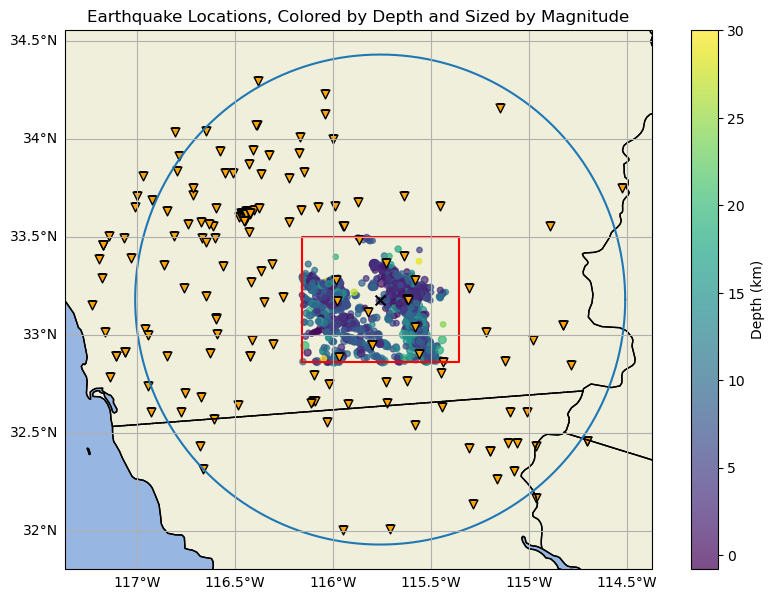

In [176]:
def plot_circle(x0, y0, r, ax, **kwargs):
    t = np.linspace(0, 2*np.pi, 2000)

    x = r * np.cos(t) + x0
    y = r * np.sin(t) + y0
    
    ax.plot(x, y, **kwargs)

lon_range = event_lon_range
lat_range = event_lat_range

# Plotting the earthquakes on a map
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adding features to the map
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES)

# Scatter plot, colored by depth and sized by magnitude
sc = ax.scatter(cat['qlon'], cat['qlat'], c=cat['qdep'], s=cat['qmag']*10, cmap='viridis', transform=ccrs.PlateCarree(), alpha=0.7)

ax.scatter(inv['slon'], inv['slat'], c='orange', s=40, marker='v', edgecolors='k', transform=ccrs.PlateCarree())

ax.scatter(np.mean(event_lon_range), np.mean(event_lat_range), c='k', s=50, marker='x', transform=ccrs.PlateCarree())

box_lon = [
    lon_range[0],
    lon_range[1],
    lon_range[1],
    lon_range[0],
    lon_range[0]
]

box_lat = [
    lat_range[0],
    lat_range[0],
    lat_range[1],
    lat_range[1],
    lat_range[0]
]
ax.plot(box_lon, box_lat, c='r')

plot_circle(np.mean(event_lon_range), np.mean(event_lat_range), station_maxradius, ax, transform=ccrs.PlateCarree())

# Adding a color bar
cb = plt.colorbar(sc, ax=ax, orientation='vertical', label='Depth (km)')
cb.set_label('Depth (km)')

# Setting the title
plt.title('Earthquake Locations, Colored by Depth and Sized by Magnitude')

# Adding gridlines and labels for lat/lon tick marks
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

# Display the plot
plt.show()


In [182]:
nchunk = 500

# remove events that have already been processed
event_ids = cat['event_id'].values.astype(int)
existing_events = [int(el) for el in os.listdir(raw_seismograms_folder) if str(el) in event_ids.astype(str)]

keep_bool = [el not in existing_events for el in event_ids]
cat = cat[keep_bool].reset_index(drop=True)


# Loop over each event
for index in trange(len(cat), desc='Downloading waveforms: '):
    ev = cat.iloc[index]

    event_id = ev['event_id']
    origin_time = UTCDateTime(ev['origin_time'])
    event_lat = ev['qlat']
    event_lon = ev['qlon']


    # Define time window
    start_time = origin_time - 30  # 30 seconds before event
    end_time = origin_time + 90    # 90 seconds after event

    # Filter out stations further than maxradius
    inv['distance'] = inv.apply(lambda x: geodesic((event_lat, event_lon), (x['slat'], x['slon'])).km, axis=1)
    relevant_stations = inv[inv['distance'] <= maxradius * 111]  # Convert degrees to km

    # Create folder for the event
    event_folder = os.path.join(raw_seismograms_folder, str(event_id))
    os.makedirs(event_folder, exist_ok=True)

    # Group stations into chunks
    station_chunks = [relevant_stations.iloc[i:i + nchunk] for i in range(0, len(relevant_stations), nchunk)]

    # Loop over each chunk of stations
    for chunk in station_chunks:
        # Collecting station information for bulk request
        bulk = [
            (str(row['net']), str(row['sta']), str(row['loc']), str(row['cha']), start_time, end_time)
            for _, row in chunk.iterrows()
        ]

        # Download the seismograms in bulk
        try:
            st = client.get_waveforms_bulk(
                bulk=bulk
            )

            # Save each stream in MiniSEED format
            for tr in st:
                net = tr.stats.network
                sta = tr.stats.station
                loc = tr.stats.location
                cha = tr.stats.channel

                filename = f"{net}.{sta}.{loc}.{cha}.mseed"
                file_path = os.path.join(event_folder, filename)
                tr.write(file_path, format="MSEED")
                # print(f"    Saved {file_path}")

        except Exception as e:
            print(f"Failed to download or save data for chunk: {e}")

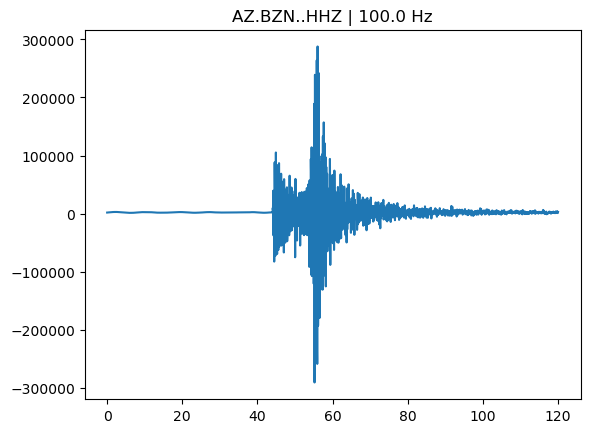

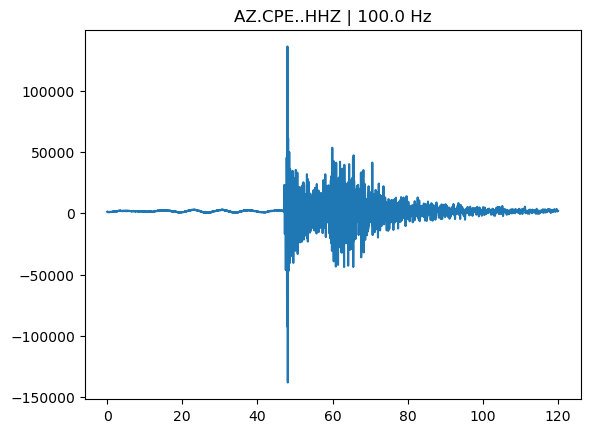

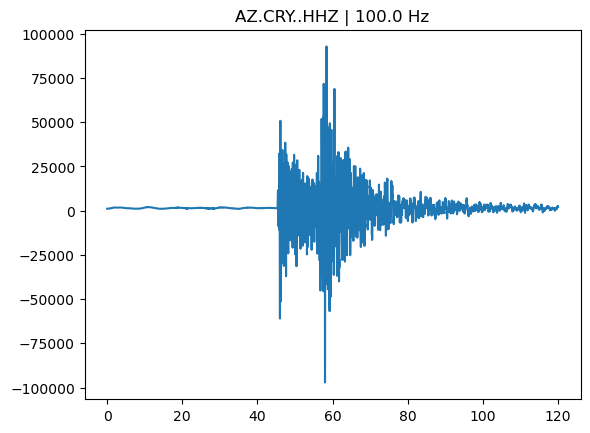

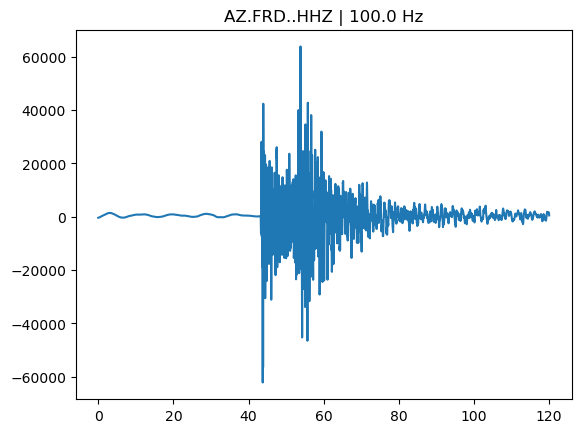

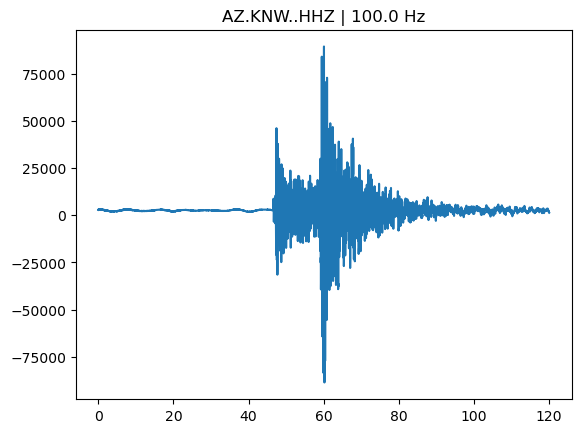

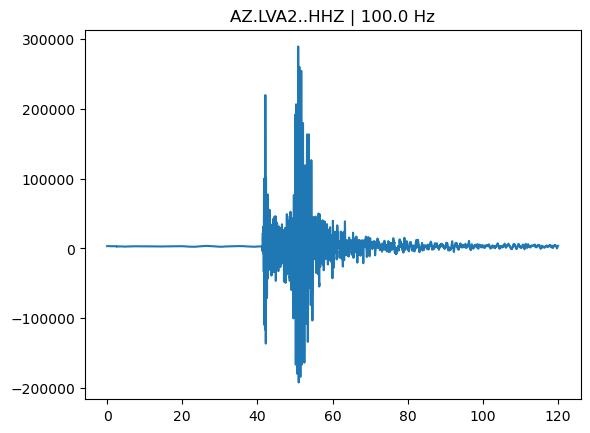

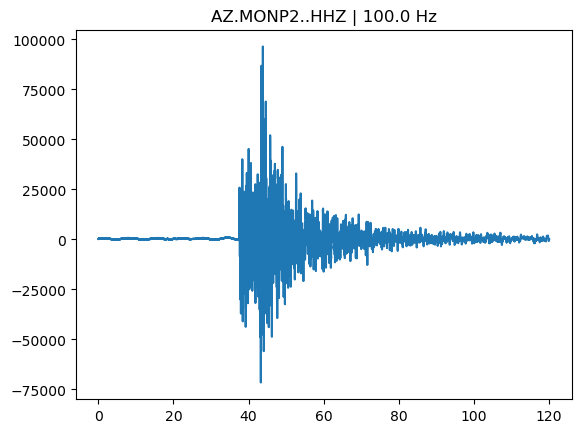

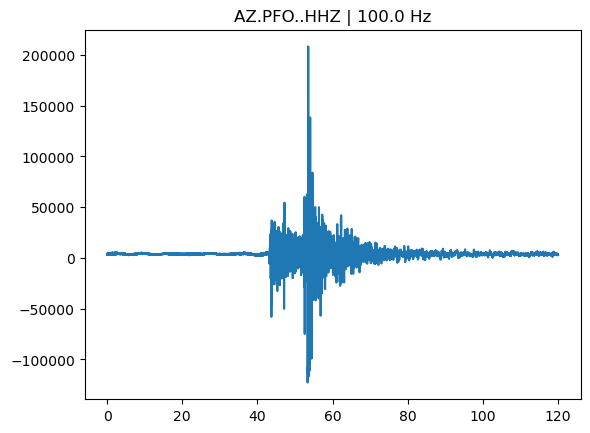

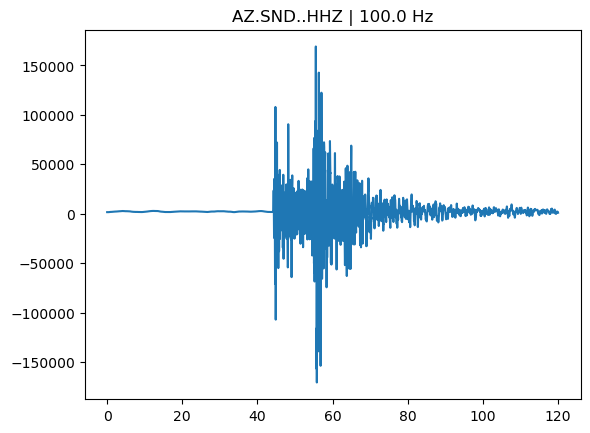

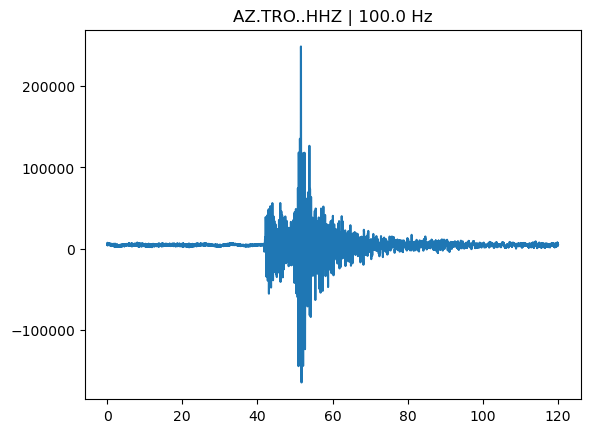

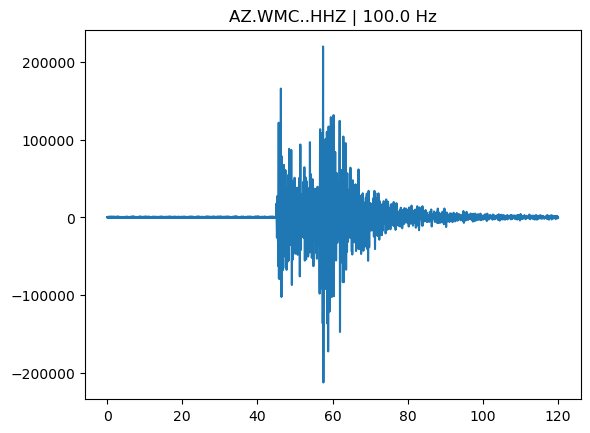

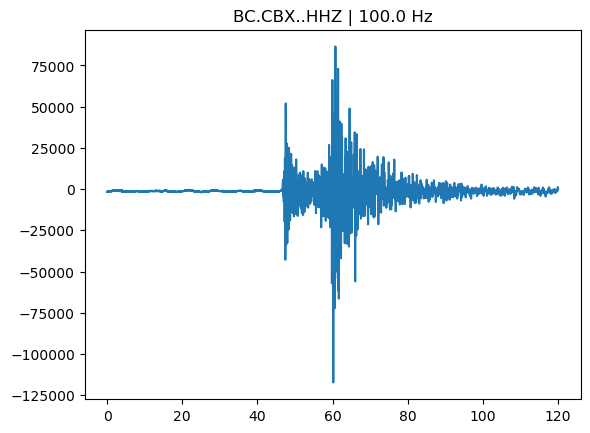

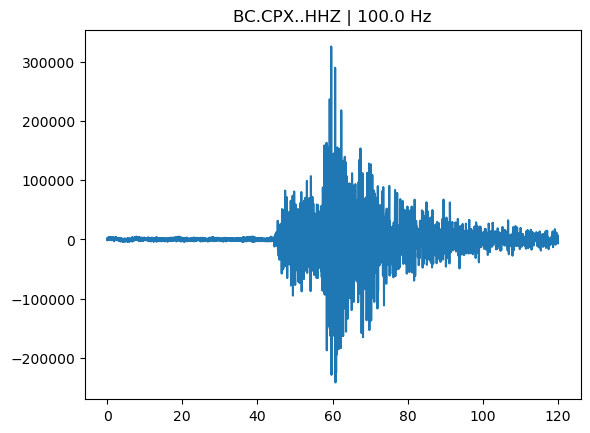

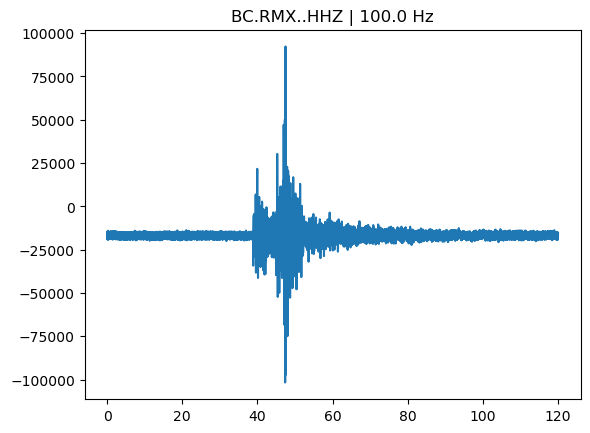

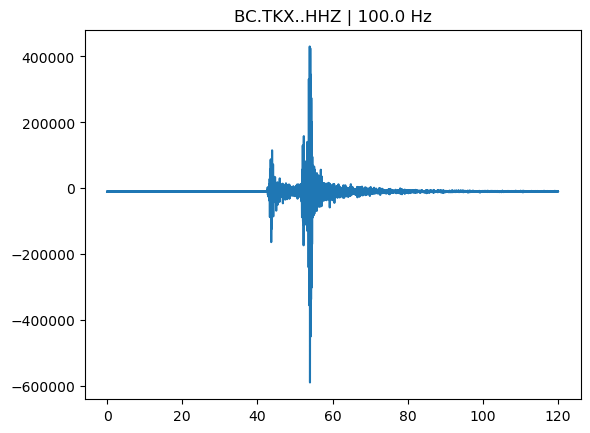

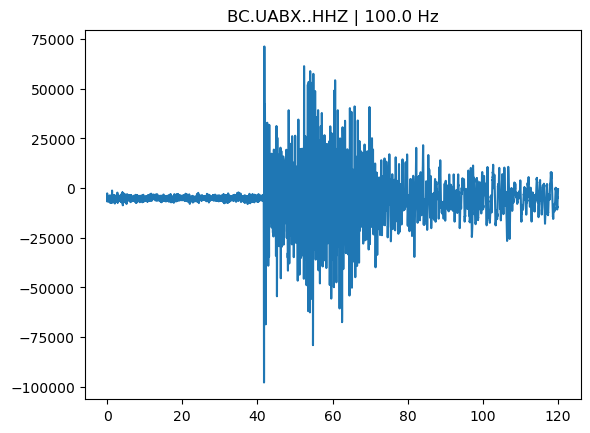

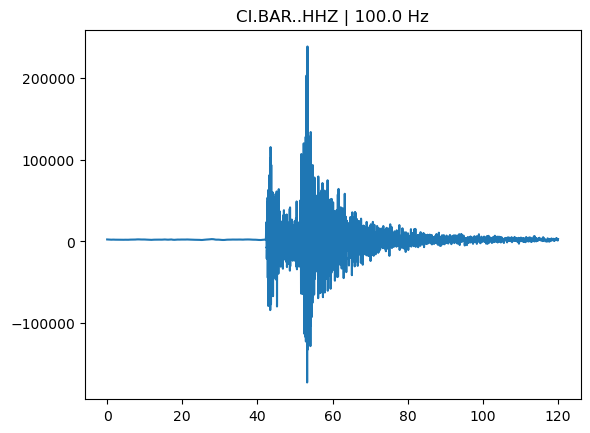

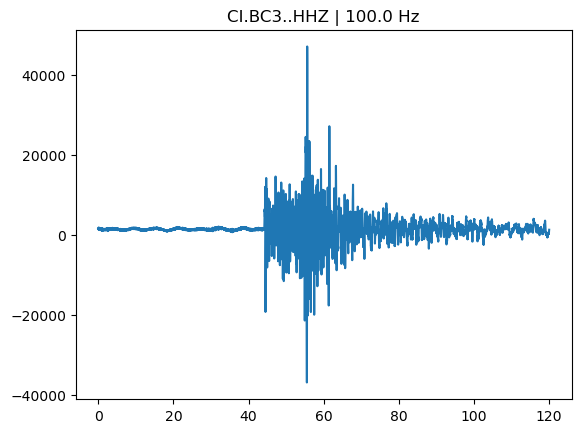

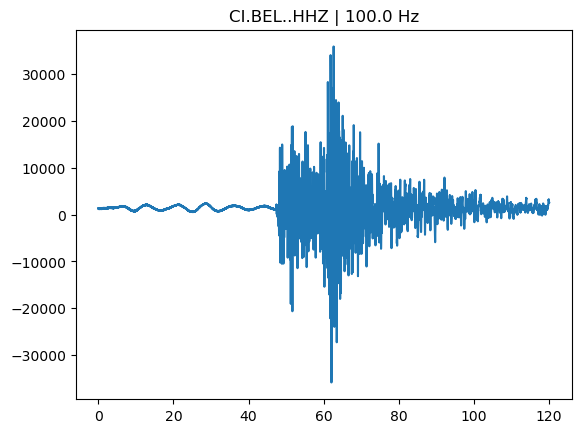

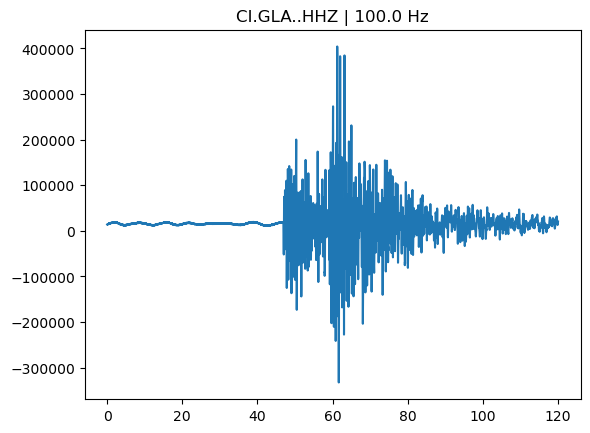

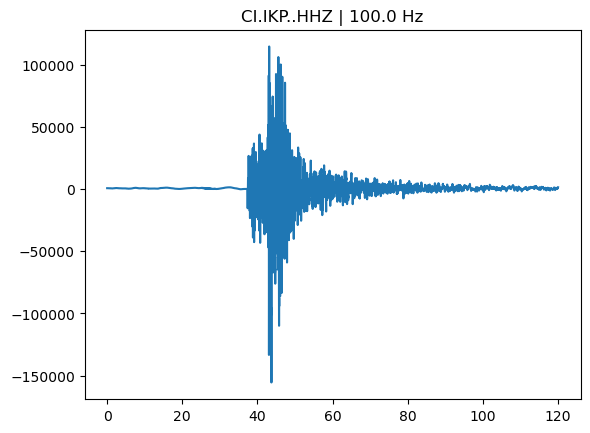

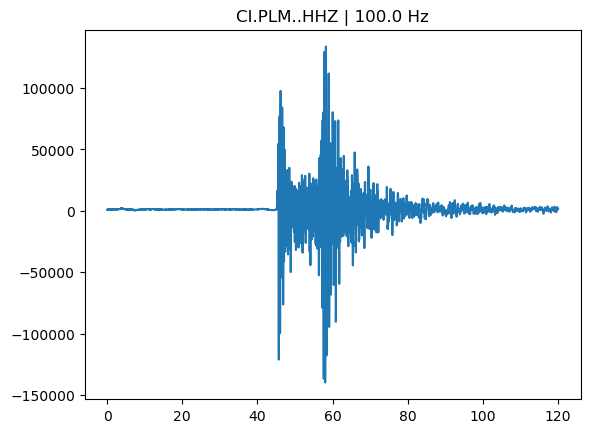

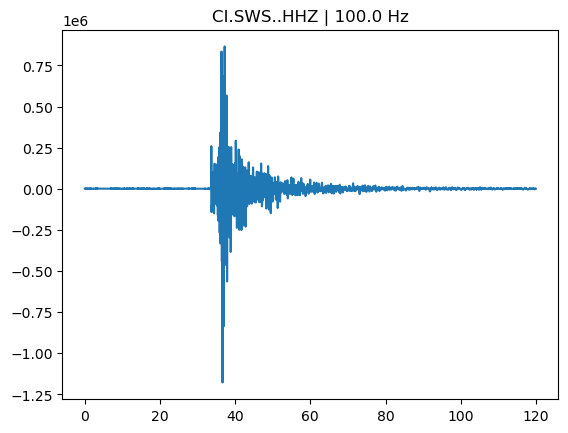

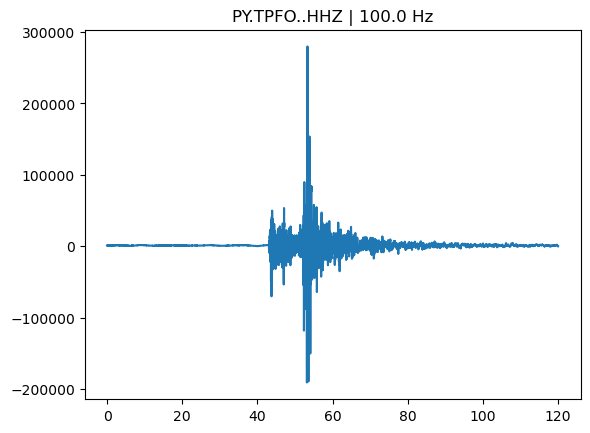

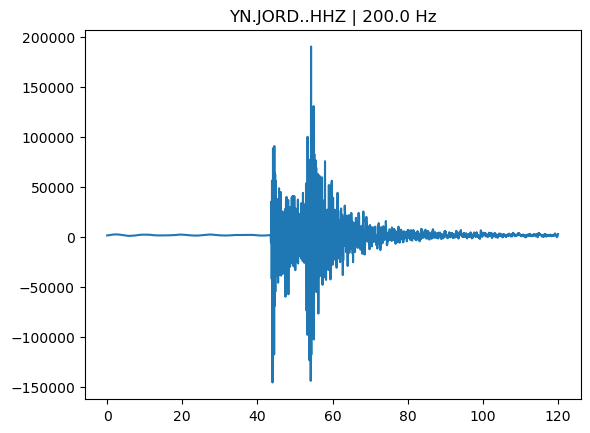

In [184]:
st = obspy.read(raw_seismograms_folder + "10975963/*.mseed")

for tr in st:
    plt.figure()
    plt.title(tr.id + " | " + f"{tr.stats.sampling_rate:.1f} Hz")
    plt.plot(tr.times(), tr.data)
    plt.show()